# Clasificador de audios de emociones

https://www.kaggle.com/ejlok1/audio-emotion-part-1-explore-data/data


https://www.kaggle.com/ejlok1/audio-emotion-part-2-feature-extract


https://www.kaggle.com/ejlok1/audio-emotion-part-3-baseline-model

María Ruiz de Castroviejo y Sergio Rincón

Hemos seleccionado este dataset porque las emociones quizá sean más relevantes que los ruidos de fondo o los sonidos de animales ya que se tratan de conversaciones entre un agente y el cliente, y hay una variedad de fuentes. 

Fuentes de datos:
 - Surrey Audio-Visual Expressed Emotion (SAVEE)
 - Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)
 - Toronto emotional speech set (TESS)
 - Crowd-sourced Emotional Mutimodal Actors Dataset (CREMA-D)

## **Exploración de datos:**

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd
import os
import sys
import warnings


if not sys.warnoptions:
    warnings.simplefilter("ignore")
    warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
TESS =  "C:/Users/María/MASTER/Datos No Estruct/Sonido/datos/TESS/TESS Toronto emotional speech set data/"
RAV =   "C:/Users/María/MASTER/Datos No Estruct/Sonido/datos/RAVDESS/audio_speech_actors_01-24/"
SAVEE = "C:/Users/María/MASTER/Datos No Estruct/Sonido/datos/SAVEE/ALL/"
CREMA = "C:/Users/María/MASTER/Datos No Estruct/Sonido/datos/CREMA-D/AudioWAV/"


dir_list = os.listdir(SAVEE)
dir_list[0:5]

['DC_a01.wav', 'DC_a02.wav', 'DC_a03.wav', 'DC_a04.wav', 'DC_a05.wav']

**1. SAVEE dataset**

Las letras del prefijo describen las clases de emoción de la siguiente manera:

'a' = 'ira'
'd' = 'disgusto'
'f' = 'miedo'
'h' = 'felicidad'
'n' = 'neutral'
'sa' = 'tristeza'
'su' = 'sorpresa'

Cada carpeta es un orador; para distinguirlos los audios se hn codificado poniendo primero el hablante Dc y después el número de oración 03. En este conjunto de datos todos los halantesson hombres.

Exploramos dos emociones diferentes para ver si la calidad de los datos (audios) es buena. Y así saber si el clasificador de audio será bueno o no:

In [3]:
dir_list = os.listdir(SAVEE)              # Directorio de SAVEE

# Parseamos las carpetas para obtener las emociones
emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('male_angry')
    elif i[-8:-6]=='_d':
        emotion.append('male_disgust')
    elif i[-8:-6]=='_f':
        emotion.append('male_fear')
    elif i[-8:-6]=='_h':
        emotion.append('male_happy')
    elif i[-8:-6]=='_n':
        emotion.append('male_neutral')
    elif i[-8:-6]=='sa':
        emotion.append('male_sad')
    elif i[-8:-6]=='su':
        emotion.append('male_surprise')
    else:
        emotion.append('male_error') 
    path.append(SAVEE + i)
    
# Hacemos un conteo de las emociones
SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.labels.value_counts()

male_neutral     120
male_happy        60
male_surprise     60
male_sad          60
male_fear         60
male_angry        60
male_disgust      60
Name: labels, dtype: int64

Necesitamos encontrar el patrón clave que nos ayudará a distinguir las diferentes emociones:

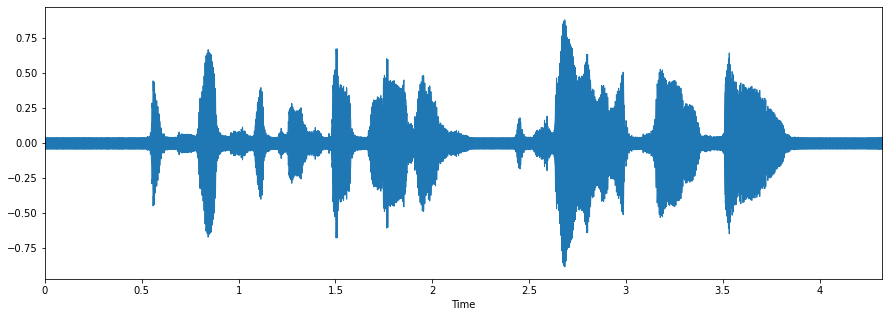

In [4]:
fname = SAVEE + 'DC_f11.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

ipd.Audio(fname)

Los datos tienen calidad ya que no hay mucho ruido de fondo y el habla es muy clara.  El gráfico de ondas no dice mucho más que una variación en la onda, lo cual es bueno para identificar claramente qué emoción transmite: miedo.

**2. RAVDESS dataset**

Identificadores de nombre de archivo según el sitio web:
 - Modalidad (01 = AV completo, 02 = solo video, 03 = solo audio).
 - Canal vocal (01 = habla, 02 = canción).
 - Emoción (01 = neutral, 02 = calma, 03 = feliz, 04 = triste, 05 = enojado, 06 = temeroso, 07 = disgusto, 08 = sorprendido).
 - Intensidad emocional (01 = normal, 02 = fuerte) NOTA: No hay una intensidad fuerte para la emoción 'neutral'.
 - Declaración (01 = "Los niños están hablando junto a la puerta", 02 = "Los perros están sentados junto a la puerta").
 - Repetición (01 = 1ª repetición, 02 = 2ª repetición).
 - Actor (01 a 24. Los actores impares son hombres, los actores pares son mujeres).


Metadatos del archivo de audio (02-01-06-01-02-01-12.mp4):

 - Solo video (02)
 - Discurso (01)
 - Temeroso (06)
 - Intensidad normal (01)
 - Declaración "perros" (02)
 - 1a repetición (01)
 - 12 ° actor (12) - Mujer (ya que el número de identificación del actor es par)

Los hablantes masculinos y femeninos deben ser entrenados por separado para obtener una buena precisión, ya que las mujeres tienen un tono más alto que los hombres. Entonces, si no etiquetamos la etiqueta de género de un audio, no se podrá detectar el enfado o miedo el hablante fuese un hombre. Simplemente se colocará en neutral.

Modelemos específicamente los 2 altavoces por separado siendo "tranquila" y "neutral" la misma categoría.

In [5]:
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

female_neutral     144
male_neutral       144
male_angry          96
female_angry        96
male_disgust        96
female_sad          96
male_fear           96
female_surprise     96
female_happy        96
male_happy          96
male_surprise       96
female_fear         96
male_sad            96
female_disgust      96
Name: labels, dtype: int64

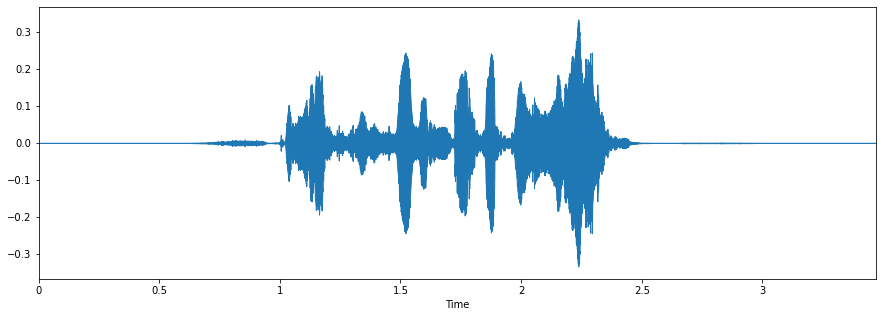

In [6]:
fname = RAV + 'Actor_14/03-01-06-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

ipd.Audio(fname)

Comorobamos que la calidad de audio es muy buena. S epuede sentir el miedo del hablante.

**3. TESS dataset**

Si no incluimos a las mujeres, terminaremos con una IA que tiene un sesgo contra un género y no es ética a menos que haya una buena razón. Por lo que en este conjunto de datos todos los hablantes son mujeres. Los oradores y las emociones están organizados en carpetas separadas.

Tiene las mismas 7 emociones clave que nos interesan. Pero en vez de tener la emoción "sorpresa" tenemos "sorpresa agradable". Habría que comprobar si en los conjuntos de datos RADVESS y SAVEE, las sorpresas son desagradables.

In [7]:
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

['OAF_Fear',
 'OAF_Pleasant_surprise',
 'OAF_Sad',
 'OAF_angry',
 'OAF_disgust',
 'OAF_happy',
 'OAF_neutral',
 'TESS Toronto emotional speech set data',
 'YAF_angry',
 'YAF_disgust',
 'YAF_fear',
 'YAF_happy',
 'YAF_neutral',
 'YAF_pleasant_surprised',
 'YAF_sad']

In [8]:
path = []
emotion = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('female_angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('female_disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('female_fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('female_happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('female_neutral')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('female_surprise')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('female_sad')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['labels'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.labels.value_counts()

female_angry       400
female_surprise    400
female_fear        400
female_neutral     400
female_sad         400
female_happy       400
female_disgust     400
Unknown             14
Name: labels, dtype: int64

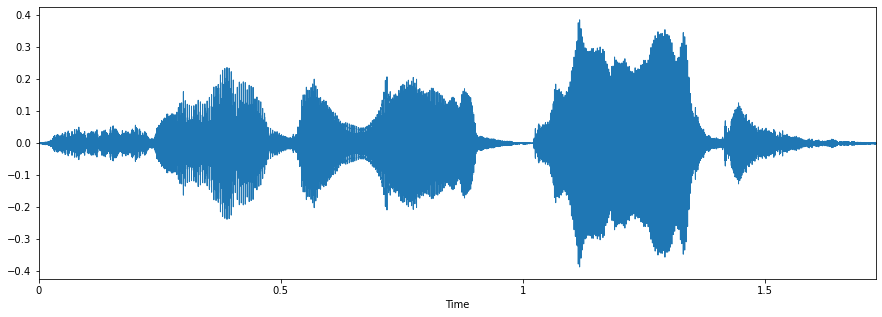

In [9]:
fname = TESS + 'YAF_fear/YAF_dog_fear.wav' 
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)


ipd.Audio(fname)

La expresión de las emociones es muy similar a RAVDESS y, por lo tanto, servirá como un buen conjunto de datos de entrenamiento. La duración del audio también es aproximadamente la misma.

**4. CREMA-D dataset**

Es un conjunto de datos muy grande y tiene una buena variedad de altavoces diferentes, aparentemente sacados de películas. Los hablantes son de diferentes etnias. Esto es bueno porque implica una mejor generalización cuando transferimos el aprendizaje. Este conjunto de datos no tiene la emoción de "sorpresa", pero podemos usar el resto.


Los hablantes y las emociones, están etiquetados en el nombre del archivo de audio. Nos falta es el género, que se guarda como un archivo csv separado que mapea a los actores.

In [10]:
dir_list = os.listdir(CREMA)
dir_list.sort()
print(dir_list[0:10])

['1001_DFA_ANG_XX.wav', '1001_DFA_DIS_XX.wav', '1001_DFA_FEA_XX.wav', '1001_DFA_HAP_XX.wav', '1001_DFA_NEU_XX.wav', '1001_DFA_SAD_XX.wav', '1001_IEO_ANG_HI.wav', '1001_IEO_ANG_LO.wav', '1001_IEO_ANG_MD.wav', '1001_IEO_DIS_HI.wav']


In [11]:
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dir_list: 
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)
    
CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()

male_angry        671
male_fear         671
male_disgust      671
male_happy        671
male_sad          671
female_happy      600
female_angry      600
female_fear       600
female_sad        600
female_disgust    600
male_neutral      575
female_neutral    512
Name: labels, dtype: int64

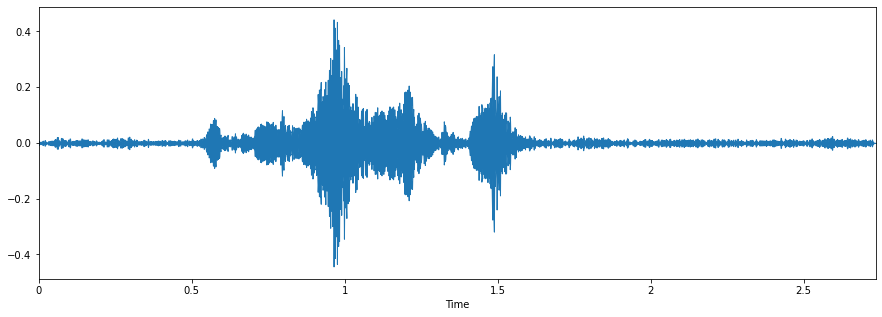

In [12]:
fname = CREMA + '1012_IEO_HAP_HI.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)
 
ipd.Audio(fname)

El audio tiene un poco de eco. No es tan claro como lo que hemos visto en los otros conjuntos de datos. Suena muy neutral en vez de feliz pero podría deberse a la calidad del audio. Comprobamos otro:

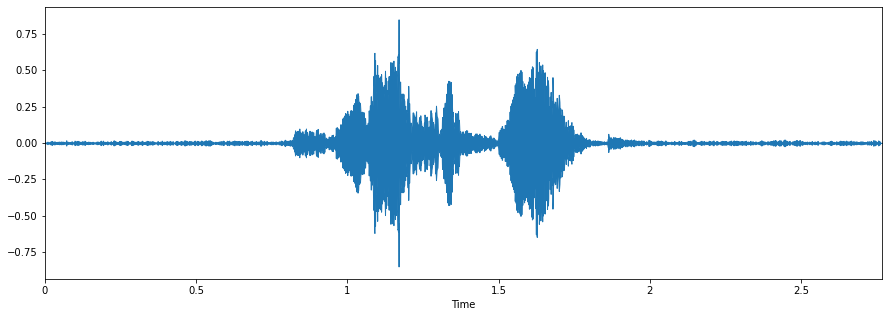

In [13]:
fname = CREMA + '1012_IEO_FEA_HI.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

ipd.Audio(fname)

Aquí si que se trasmite miedo. Este conjunto de datos CREMA-D es que es muy variado en su calidad. Algunos audios son claros y nítidos y otras son  apagados o con eco. También hay mucho silencio. Por lo que es una versión que quizá introdue un poco de ruido pero como los datos siguen siendo de buena calidad, los usaremos. 

En resumidas cuentas los 4 conjuntos de datos son buenos. Necesitamos combinarlos todos para evitar el sobreajuste y que funcione bien en un nuevo conjunto de datos no visto.

Combinamos todos los metadatos en uno solo:

In [14]:
df = pd.concat([SAVEE_df, RAV_df, TESS_df, CREMA_df], axis = 0)
print(df.labels.value_counts())
df.head()
df.to_csv("Data_path.csv",index=False)

female_angry       1096
female_sad         1096
female_disgust     1096
female_happy       1096
female_fear        1096
female_neutral     1056
male_neutral        839
male_angry          827
male_fear           827
male_disgust        827
male_sad            827
male_happy          827
female_surprise     496
male_surprise       156
Unknown              14
Name: labels, dtype: int64


## **Extracción de caracterísicas:**

En términos generales, hay dos categorías de características:

- **Características del dominio del tiempo**: son más simples de extraer y comprender (energía de la señal, la tasa de cruce, amplitud, energía, etc).


- **Funciones basadas en frecuencia**: se obtienen convirtiendo la señal basada en el tiempo en el dominio de la frecuencia. Son más difíciles de comprender, proporciona información adicional que puede ser realmente útil (tono, ritmos, melodía, etc).

Usaremos MFCC porque es la mejor característica para este problema. Más adelante, durante la fase de mejora de la precisión, podemos ampliar nuestro conjunto de funciones para incluir Mel-Spectogram, Chroma, HPSS, etc., y no solo un medio simple.

**1. MFCC**

El coeficiente cepstral de frecuencia Mel es una buena "representación" del tracto vocal que produce el sonido. La aplicación de aprendizaje automático más común trata al MFCC en sí mismo como una 'imagen' y se convierte en una función ofreciendo una buena predicción.

El beneficio de tratarlo como una imagen es que proporciona más información y le da a uno la capacidad de aprovechar el aprendizaje por transferencia.

In [15]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import pandas as pd
import os
import IPython.display as ipd

**2. Deepdive**

Podemos seleccionar algunos ejemplos y visualizar el MFCC. Seleccionamos 2 emociones diferentes y 2 géneros diferentes para ver si la calidad de los datos (audios) es buena:

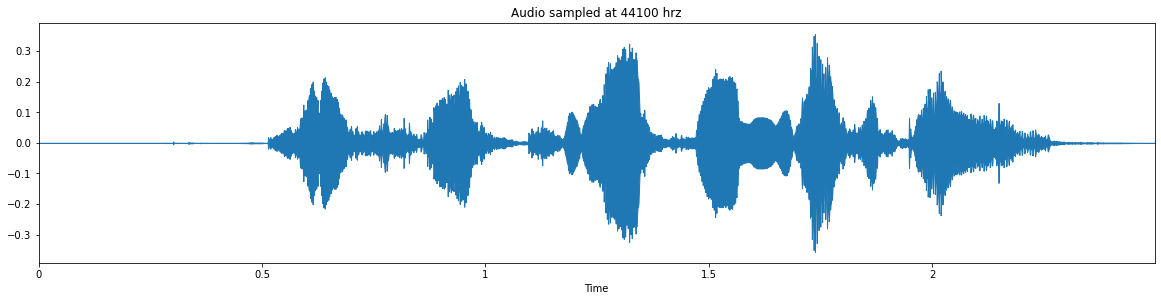

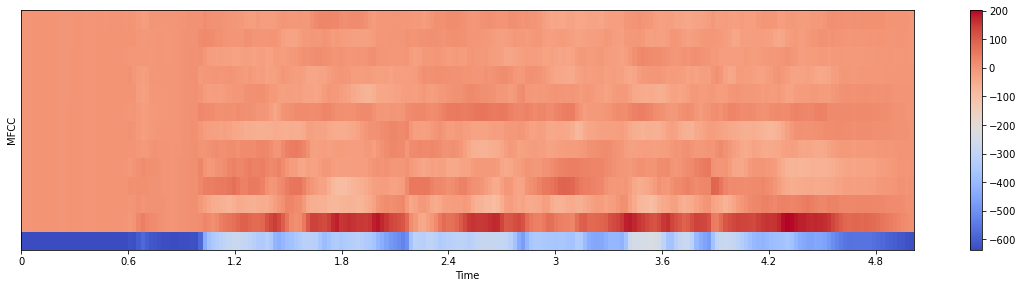

In [19]:
# Fuente RAVDESS
# Género Femenino
# Emoción Enfado

path = "C:/Users/María/MASTER/Datos No Estruct/Sonido/datos/RAVDESS/audio_speech_actors_01-24/Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# Onda de sonido
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

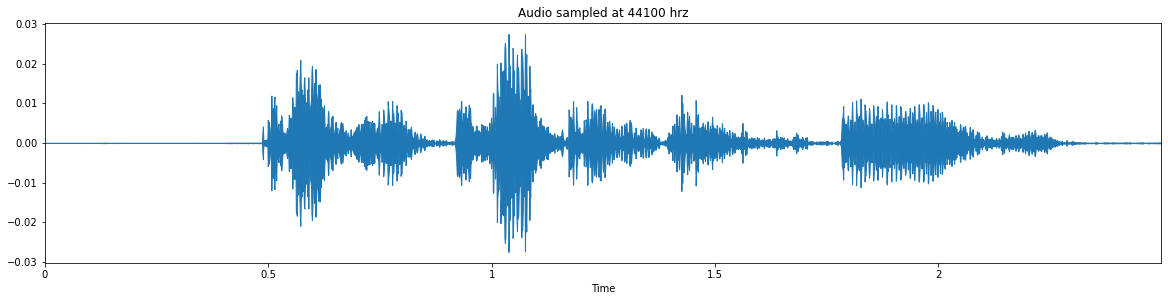

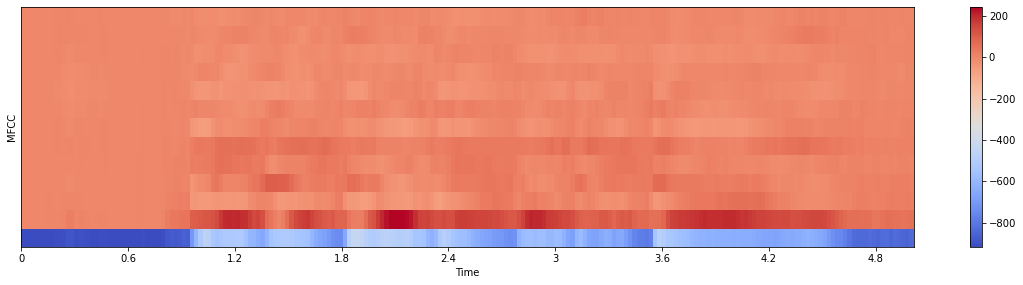

In [20]:
# Fuente RAVDESS
# Género Masculino
# Emoción Enfado

path = "C:/Users/María/MASTER/Datos No Estruct/Sonido/datos/RAVDESS/audio_speech_actors_01-24/Actor_09/03-01-05-01-01-01-09.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# Onda de sonido
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

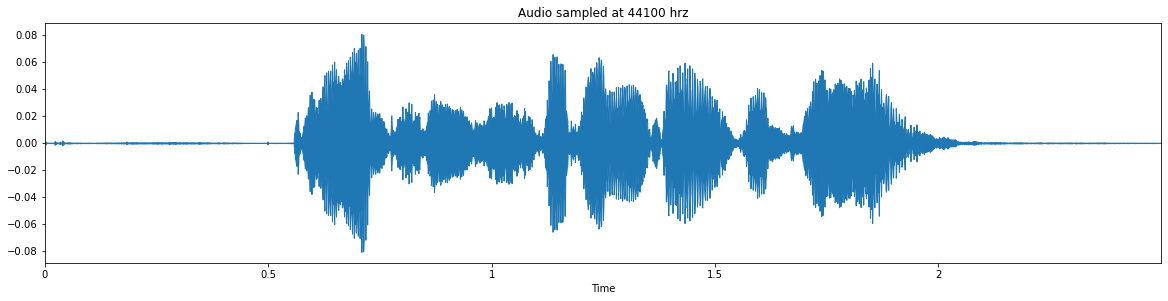

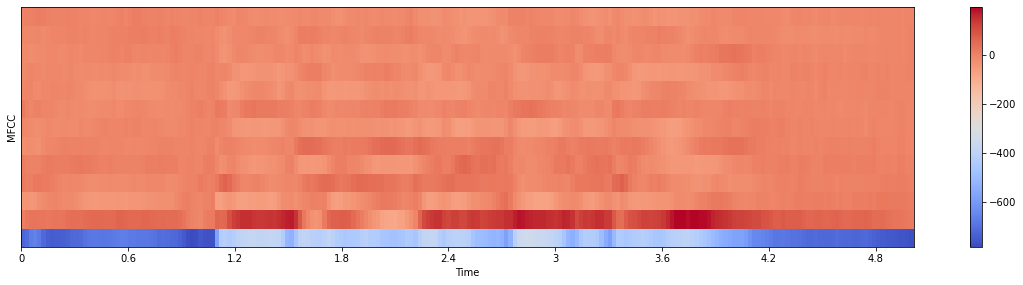

In [21]:
# Fuente RAVDESS
# Género Femenino
# Emoción Felicidad

path = "C:/Users/María/MASTER/Datos No Estruct/Sonido/datos/RAVDESS/audio_speech_actors_01-24/Actor_12/03-01-03-01-02-01-12.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# Onda de sonido
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

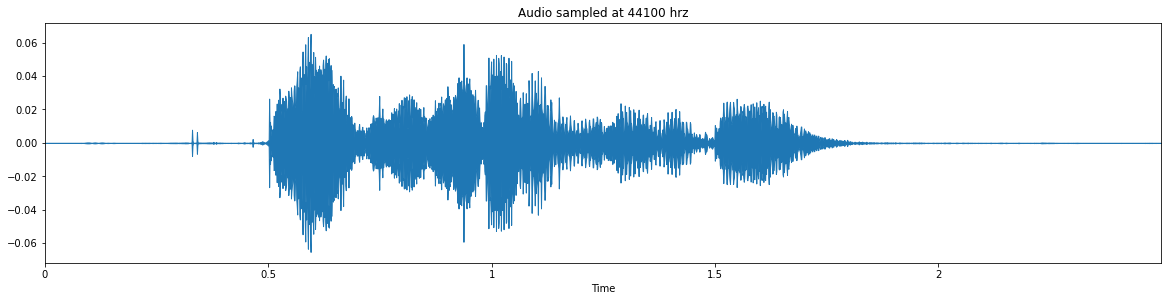

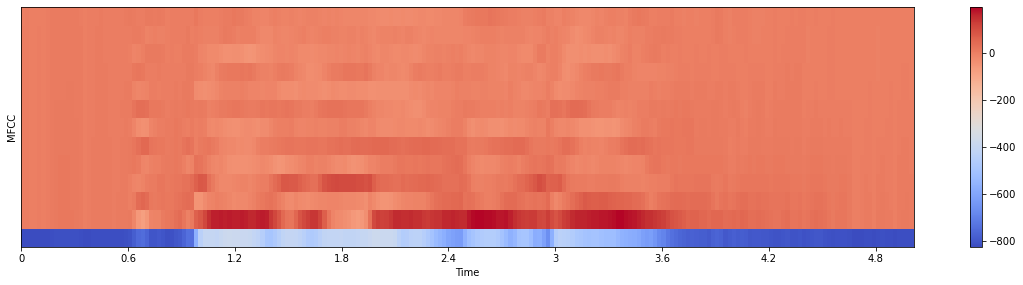

In [22]:
# Fuente RAVDESS
# Género Masculino
# Emoción Felicidad

path = "C:/Users/María/MASTER/Datos No Estruct/Sonido/datos/RAVDESS/audio_speech_actors_01-24/Actor_11/03-01-03-01-02-02-11.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# Onda de sonido
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

**3. Características estadísticas**

Hemos visto la  salida MFCC para cada archivo, y es un formato de matriz 2D. En este apartado se va a calcular la media de cada banda a lo largo del tiempo para ver si la primera banda en la parte inferior es la banda más distintiva sobre las otras bandas. 

Dado que la ventana de tiempo es corta, los cambios observados con el tiempo no varían mucho. Vamos a comparar a la mujer y el hombre enfadados con la misma oración pronunciada.

216
216


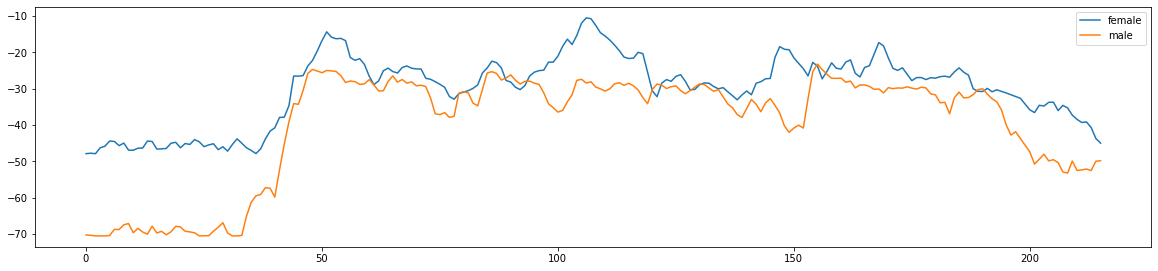

In [23]:
# Fuente RAVDESS
# Género Femenino
# Emoción Enfado
path = "C:/Users/María/MASTER/Datos No Estruct/Sonido/datos/RAVDESS/audio_speech_actors_01-24/Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Fuente RAVDESS
# Género Masculino
# Emoción Enfado
path = "C:/Users/María/MASTER/Datos No Estruct/Sonido/datos/RAVDESS/audio_speech_actors_01-24/Actor_09/03-01-05-01-01-01-09.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# Ondas de sonido
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

Para la misma oración que se pronuncia, hay una clara diferencia distintiva entre hombres y mujeres ya que las mujeres tienden a tener un tono más alto.

216
216


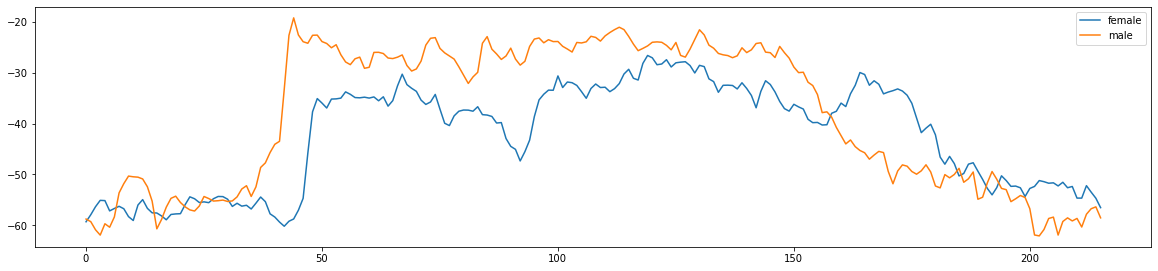

In [24]:
# Fuente RAVDESS
# Género Femenino
# Emoción Felicidad
path = "C:/Users/María/MASTER/Datos No Estruct/Sonido/datos/RAVDESS/audio_speech_actors_01-24/Actor_12/03-01-03-01-02-01-12.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Fuente RAVDESS
# Género Masculino
# Emoción Felicidad
path = "C:/Users/María/MASTER/Datos No Estruct/Sonido/datos/RAVDESS/audio_speech_actors_01-24/Actor_11/03-01-03-01-02-02-11.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# Ondas de sonido
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

Concluímos que el uso de MFCC es una buena característica para diferenciar el género y las emociones.

## **Modelado de datos:**

En este apartado crearemos el clasificador de emociones.

In [2]:
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import json
import seaborn as sns
import pickle

**1. Preparación y procesamiento de datos**

Ejecutar un bucle sobre el archivo de los metadatos para leer todos los archivos de audio distribuidos en los 4 directorios. Hay que poner la ruta a los archivos de audio sin procesar para el entrenamiento.

In [3]:
ref = pd.read_csv("./datos/Data_path.csv")
ref.head()

labels source                          path
0  male_neutral  SAVEE  ./datos/SAVEE/ALL/JE_n18.wav
1    male_angry  SAVEE  ./datos/SAVEE/ALL/DC_a01.wav
2  male_neutral  SAVEE  ./datos/SAVEE/ALL/JE_n05.wav
3    male_angry  SAVEE  ./datos/SAVEE/ALL/JK_a12.wav
4  male_neutral  SAVEE  ./datos/SAVEE/ALL/JE_n29.wav

Para optimizar  la memoria, vamos a leer cada archivo de audio, extraer su media en todas las bandas de MFCC por tiempo y  mantener las características extraídas, eliminando todos los datos del archivo de audio.

In [6]:
df = pd.DataFrame(columns=['feature'])

counter=0
for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast' ,duration=2.5 ,sr=44100,offset=0.5)
    sample_rate = np.array(sample_rate)
    
    # Media
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1   

In [7]:
print(len(df))
df.head()

12162


feature
0  [-25.37692, -24.842583, -25.312065, -24.858978...
1  [-11.113933, -7.215756, -6.21919, -5.9265423, ...
2  [-27.450249, -26.854015, -26.683601, -27.64807...
3  [-5.2345457, -6.68739, -16.406271, -17.042978,...
4  [-28.316051, -28.18612, -27.667513, -19.379509...

**2. Procesamiento de datos**

In [8]:
# Extraemos las medias de las bandas
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df[:5]

labels source                          path          0          1  \
0  male_neutral  SAVEE  ./datos/SAVEE/ALL/JE_n18.wav -25.376921 -24.842583   
1    male_angry  SAVEE  ./datos/SAVEE/ALL/DC_a01.wav -11.113933  -7.215756   
2  male_neutral  SAVEE  ./datos/SAVEE/ALL/JE_n05.wav -27.450249 -26.854015   
3    male_angry  SAVEE  ./datos/SAVEE/ALL/JK_a12.wav  -5.234546  -6.687390   
4  male_neutral  SAVEE  ./datos/SAVEE/ALL/JE_n29.wav -28.316051 -28.186119   

           2          3          4          5          6  ...        206  \
0 -25.312065 -24.858978 -26.600643 -26.726088 -25.850971  ...        NaN   
1  -6.219190  -5.926542  -5.850419  -4.808960  -2.513003  ...  -4.088852   
2 -26.683601 -27.648075 -28.751026 -30.146671 -28.018799  ...  -5.983145   
3 -16.406271 -17.042978 -16.232887 -14.091496 -13.224945  ... -26.130611   
4 -27.667513 -19.379509 -11.144134  -8.123636  -8.312649  ... -27.069855   

         207        208        209        210        211        212  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1  -5.023864  -5.254714  -5.234095  -5.310307  -5.621666  -6.072197   
2  -6.797940  -7.641076  -8.502519  -8.663111 -11.605281 -16.408430   
3 -26.350634 -25.106792 -23.058765 -23.787733 -23.516254 -24.285072   
4 -27.943575 -28.134996 -28.179310 -28.849735 -28.935709 -28.182568   

         213        214        215  
0        NaN        NaN        NaN  
1  -6.611348  -2.509089   1.964608  
2 -19.296211 -22.340641 -24.666119  
3 -23.437519 -22.714952 -23.930023  
4 -29.281555 -29.144468 -27.194292  

[5 rows x 219 columns]

In [9]:
# Reemplazamos los NA con 0
df=df.fillna(0)
print(df.shape)
df[:5]

(12162, 219)


labels source                          path          0          1  \
0  male_neutral  SAVEE  ./datos/SAVEE/ALL/JE_n18.wav -25.376921 -24.842583   
1    male_angry  SAVEE  ./datos/SAVEE/ALL/DC_a01.wav -11.113933  -7.215756   
2  male_neutral  SAVEE  ./datos/SAVEE/ALL/JE_n05.wav -27.450249 -26.854015   
3    male_angry  SAVEE  ./datos/SAVEE/ALL/JK_a12.wav  -5.234546  -6.687390   
4  male_neutral  SAVEE  ./datos/SAVEE/ALL/JE_n29.wav -28.316051 -28.186119   

           2          3          4          5          6  ...        206  \
0 -25.312065 -24.858978 -26.600643 -26.726088 -25.850971  ...   0.000000   
1  -6.219190  -5.926542  -5.850419  -4.808960  -2.513003  ...  -4.088852   
2 -26.683601 -27.648075 -28.751026 -30.146671 -28.018799  ...  -5.983145   
3 -16.406271 -17.042978 -16.232887 -14.091496 -13.224945  ... -26.130611   
4 -27.667513 -19.379509 -11.144134  -8.123636  -8.312649  ... -27.069855   

         207        208        209        210        211        212  \
0   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
1  -5.023864  -5.254714  -5.234095  -5.310307  -5.621666  -6.072197   
2  -6.797940  -7.641076  -8.502519  -8.663111 -11.605281 -16.408430   
3 -26.350634 -25.106792 -23.058765 -23.787733 -23.516254 -24.285072   
4 -27.943575 -28.134996 -28.179310 -28.849735 -28.935709 -28.182568   

         213        214        215  
0   0.000000   0.000000   0.000000  
1  -6.611348  -2.509089   1.964608  
2 -19.296211 -22.340641 -24.666119  
3 -23.437519 -22.714952 -23.930023  
4 -29.281555 -29.144468 -27.194292  

[5 rows x 219 columns]

Dividimos el conjunto de datos en entrenamiento y test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels, test_size=0.25, shuffle=True, random_state=42 )

X_train[150:160]

0          1          2          3          4          5    \
4950  -18.611181 -17.616535 -18.411484 -18.987421 -17.404621 -16.747272   
3860  -17.367287 -21.216661 -27.259260 -27.316660 -28.886757 -31.021536   
9761   -1.533947  -4.030602  -9.614023 -12.045173  -9.992991 -11.926252   
7620   -4.531077  -3.933794  -4.567834  -5.871509  -5.282474  -6.490458   
11586 -20.621702 -21.587507 -20.563650 -20.703461 -21.205717 -18.608530   
7914  -17.514992 -18.551868 -17.043013 -16.977905 -19.369631 -19.562126   
9513  -18.740364 -18.824934 -16.149492 -16.963453 -18.229979 -18.183958   
5835  -19.066851 -18.328382 -17.710285 -18.043194 -18.252481 -18.710627   
5389  -20.760592 -20.047142 -18.961346 -19.468687 -19.316292 -18.162565   
11222 -18.252926 -17.727369 -19.222475 -18.469973 -17.572329 -17.850542   

             6          7          8          9    ...        206        207  \
4950  -17.733749 -18.055027 -17.931210 -15.913172  ... -22.899403 -21.647814   
3860  -28.050455 -27.100910 -26.216240 -25.999886  ...   0.000000   0.000000   
9761  -14.008465 -13.561556 -14.024567 -15.151947  ...   0.000000   0.000000   
7620   -8.156467  -9.188803  -8.681726  -8.212409  ...   0.000000   0.000000   
11586 -18.446669 -16.211843 -14.257653 -15.160404  ...   0.000000   0.000000   
7914  -22.008749 -20.178383 -17.989597 -19.336285  ...   0.000000   0.000000   
9513  -19.274342 -18.395124 -16.951286 -16.672031  ... -17.882132 -19.390713   
5835  -16.626354 -17.831005 -18.028345 -17.859106  ...   0.000000   0.000000   
5389  -18.102333 -19.914131 -20.931385 -19.215496  ...   0.000000   0.000000   
11222 -17.932026 -20.588900 -18.612185 -15.990725  ... -18.065437 -18.135092   

             208        209        210        211        212        213  \
4950  -19.758650 -18.879402 -19.397377 -20.171659 -22.689240 -24.612816   
3860    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
9761    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
7620    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
11586   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
7914    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
9513  -17.779476 -19.165974   0.000000   0.000000   0.000000   0.000000   
5835    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
5389    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
11222 -19.665306 -20.741903 -20.273037 -18.371035 -15.576725 -17.512487   

             214        215  
4950  -24.153774 -22.703133  
3860    0.000000   0.000000  
9761    0.000000   0.000000  
7620    0.000000   0.000000  
11586   0.000000   0.000000  
7914    0.000000   0.000000  
9513    0.000000   0.000000  
5835    0.000000   0.000000  
5389    0.000000   0.000000  
11222 -17.008547 -18.195280  

[10 rows x 216 columns]

Como estamos mezclando algunas fuentes de datos diferentes, hay que normalizar los datos para mejorar la precisión y el proceso de entrenamiento. 

In [11]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

X_train[150:160]

0         1         2         3         4         5         6    \
4950   0.185986  0.302547  0.436216  0.387012  0.497589  0.542060  0.460953   
3860   0.273032  0.040719 -0.221177 -0.230337 -0.351758 -0.513618 -0.300603   
9761   1.381017  1.290619  1.089871  0.901560  1.045836  0.898606  0.735945   
7620   1.171284  1.297659  1.464805  1.359141  1.394278  1.300620  1.167925   
11586  0.045294  0.013748  0.276309  0.259822  0.216418  0.404407  0.408327   
7914   0.262695  0.234522  0.537894  0.535954  0.352235  0.333882  0.145382   
9513   0.176946  0.214663  0.604283  0.537025  0.436536  0.435807  0.347230   
5835   0.154100  0.250776  0.488315  0.456996  0.434872  0.396856  0.542698   
5389   0.035575  0.125775  0.395361  0.351341  0.356181  0.437389  0.433745   
11222  0.211056  0.294486  0.375959  0.425364  0.485184  0.460465  0.446316   

            7         8         9    ...       206       207       208  \
4950   0.431746  0.434787  0.580609  ... -0.877956 -0.811298 -0.690761   
3860  -0.235339 -0.175869 -0.163161  ...  0.540144  0.526610  0.526006   
9761   0.763115  0.722730  0.636740  ...  0.540144  0.526610  0.526006   
7620   1.085582  1.116530  1.148445  ...  0.540144  0.526610  0.526006   
11586  0.567671  0.705550  0.636116  ...  0.540144  0.526610  0.526006   
7914   0.275160  0.430484  0.328197  ...  0.540144  0.526610  0.526006   
9513   0.406666  0.507013  0.524653  ... -0.567249 -0.671802 -0.568881   
5835   0.448266  0.427628  0.437121  ...  0.540144  0.526610  0.526006   
5389   0.294647  0.213656  0.337104  ...  0.540144  0.526610  0.526006   
11222  0.244887  0.384595  0.574891  ... -0.578601 -0.594200 -0.685013   

            209       210       211       212       213       214       215  
4950  -0.629001 -0.675062 -0.717815 -0.860972 -0.984873 -0.969587 -0.878612  
3860   0.526618  0.511547  0.511441  0.512463  0.500913  0.495901  0.491369  
9761   0.526618  0.511547  0.511441  0.512463  0.500913  0.495901  0.491369  
7620   0.526618  0.511547  0.511441  0.512463  0.500913  0.495901  0.491369  
11586  0.526618  0.511547  0.511441  0.512463  0.500913  0.495901  0.491369  
7914   0.526618  0.511547  0.511441  0.512463  0.500913  0.495901  0.491369  
9513  -0.646542  0.511547  0.511441  0.512463  0.500913  0.495901  0.491369  
5835   0.526618  0.511547  0.511441  0.512463  0.500913  0.495901  0.491369  
5389   0.526618  0.511547  0.511441  0.512463  0.500913  0.495901  0.491369  
11222 -0.743006 -0.728629 -0.608085 -0.430434 -0.556252 -0.536063 -0.606593  

[10 rows x 216 columns]

Necesitaremos convertir el formato de datos a una matriz numérica, porque estamos usando keras CNN 2D.

In [12]:
# Formateamos los conjutnos de datos
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# One hot Encoding para dicotomicar variables
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)

filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(9121, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


Ahora que estamos usando una CNN, necesitamos especificar la tercera dimensión, que para nosotros es 1 porque estamos haciendo una CNN 1D y no una CNN 2D. Si usamos los datos de MFCC en su totalidad lo podemos convertir en una CNN 2D.

In [13]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(9121, 216, 1)

**2. Modelado**

In [28]:
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14))
model.add(Activation('softmax'))

In [35]:
from tensorflow import keras
from tensorflow.keras import layers

opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 216, 256)          2304      
_________________________________________________________________
activation_36 (Activation)   (None, 216, 256)          0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 216, 256)          524544    
_________________________________________________________________
batch_normalization_8 (Batch (None, 216, 256)          1024      
_________________________________________________________________
activation_37 (Activation)   (None, 216, 256)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 216, 256)          0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 27, 256)          

In [37]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=60, validation_data=(X_test, y_test))

Epoch 1/60
571/571 [==============================] - 103s 177ms/step - loss: 2.2928 - accuracy: 0.2372 - val_loss: 2.2942 - val_accuracy: 0.2545
Epoch 2/60
571/571 [==============================] - 99s 174ms/step - loss: 2.1668 - accuracy: 0.2641 - val_loss: 2.1913 - val_accuracy: 0.2736
Epoch 3/60
571/571 [==============================] - 98s 172ms/step - loss: 2.0626 - accuracy: 0.2985 - val_loss: 2.1108 - val_accuracy: 0.3249
Epoch 4/60
571/571 [==============================] - 98s 171ms/step - loss: 1.9859 - accuracy: 0.3192 - val_loss: 2.0748 - val_accuracy: 0.3413
Epoch 5/60
571/571 [==============================] - 100s 175ms/step - loss: 1.9382 - accuracy: 0.3392 - val_loss: 2.0278 - val_accuracy: 0.3489
Epoch 6/60
571/571 [==============================] - 104s 181ms/step - loss: 1.8821 - accuracy: 0.3542 - val_loss: 1.9992 - val_accuracy: 0.3568
Epoch 7/60
571/571 [==============================] - 101s 176ms/step - loss: 1.8539 - accuracy: 0.3689 - val_loss: 1.9542 - va

Epoch 57/60
571/571 [==============================] - 109s 191ms/step - loss: 1.2375 - accuracy: 0.5811 - val_loss: 1.6046 - val_accuracy: 0.4476
Epoch 58/60
571/571 [==============================] - 101s 176ms/step - loss: 1.1985 - accuracy: 0.5926 - val_loss: 1.5815 - val_accuracy: 0.4535
Epoch 59/60
571/571 [==============================] - 101s 177ms/step - loss: 1.2051 - accuracy: 0.5890 - val_loss: 1.5967 - val_accuracy: 0.4489
Epoch 60/60
571/571 [==============================] - 107s 188ms/step - loss: 1.1861 - accuracy: 0.5958 - val_loss: 1.6155 - val_accuracy: 0.4403


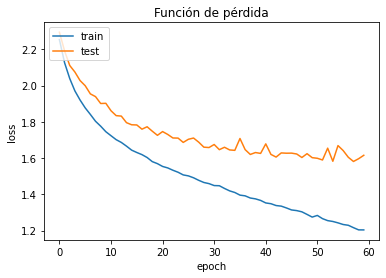

In [40]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Función de pérdida')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

La función de pérdida comienza a estabilizarse en 50 épocas pero lo mantendremos en 60.

**3. Serialización del modelo**

Guardamos el modelo para su reutilización:

In [41]:
#  Gaurdamos la arquitectura del modelo y los pesos
model_name = 'Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Guardamos el modelo y los pesos en %s ' % model_path)

# Guardamos en disco
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Guardamos el modelo y los pesos en C:\Users\María\MASTER\Datos No Estruct\Sonido\saved_models\Emotion_Model.h5 


**4. Validación del modelo**

Para validar el modelo predecimos las emociones con los datos de la prueba. Cargamos el modelo serializado anterior sin tener que volverlo a entrenar. En la última época 60, tenemos una precisión del 44.03%

In [44]:
# Cargamos el JSON
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Cargamos los pesos
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Cargamos el modelo guardado con una precisión del")
 
# optimizador Keras
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Cargamos el modelo guardado con una precisión del
accuracy: 44.03%


In [45]:
preds= loaded_model.predict(X_test,batch_size=16, verbose=1)
preds= preds.argmax(axis=1)
preds

191/191 [==============================] - 5s 27ms/step


array([ 3,  0,  8, ..., 13,  4,  0], dtype=int64)

In [46]:
# Predicciones
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Etiquetas
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Salida
finaldf = actual.join(preds)
finaldf[170:180]

actualvalues predictedvalues
170        male_sad        male_sad
171  female_disgust  female_disgust
172      male_angry    female_angry
173  female_disgust  female_disgust
174      male_angry      male_angry
175     female_fear     female_fear
176    male_disgust    male_neutral
177     female_fear    male_neutral
178    female_happy  female_neutral
179  female_neutral  female_neutral

In [47]:
# Guardamos las predicciones en disco
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

actualvalues
predictedvalues              
female_angry              426
female_disgust            331
female_fear               199
female_happy              400
female_neutral            343
female_sad                370
female_surprise           138
male_angry                148
male_disgust               88
male_fear                  36
male_happy                 69
male_neutral              350
male_sad                  101
male_surprise              42

Para saber como de lo hemos hecho estudiamos el prcentaje de registros donde Real = Predicho.

In [48]:
# Representaciónde la matriz de cnfusión mediante un mapa de calor
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Recodificación de género
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

Exactitud de la emoción por género:

0.44031568562972706


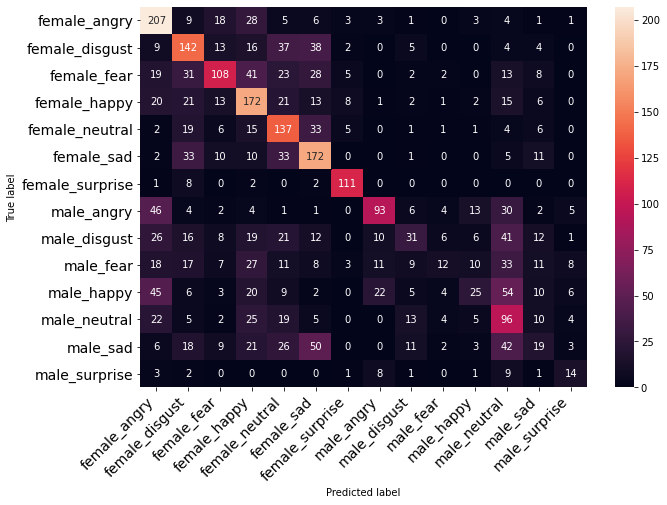

In [49]:
# Predicciones
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Matriz de confusión
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [50]:
# Fichero de clasificación
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.49      0.72      0.58       289
 female_disgust       0.43      0.53      0.47       270
    female_fear       0.54      0.39      0.45       280
   female_happy       0.43      0.58      0.49       295
 female_neutral       0.40      0.60      0.48       230
     female_sad       0.46      0.62      0.53       277
female_surprise       0.80      0.90      0.85       124
     male_angry       0.63      0.44      0.52       211
   male_disgust       0.35      0.15      0.21       209
      male_fear       0.33      0.06      0.11       185
     male_happy       0.36      0.12      0.18       211
   male_neutral       0.27      0.46      0.34       210
       male_sad       0.19      0.09      0.12       210
  male_surprise       0.33      0.35      0.34        40

       accuracy                           0.44      3041
      macro avg       0.43      0.43      0.41      3041
   weighted avg       0.43   

La precisión absoluta para el género por emociones es del 44% lo cual está basante bien. Como la clasificación de género es más precisa, agrupamos y medimos la precisión de nuevo:

0.7836238079579085


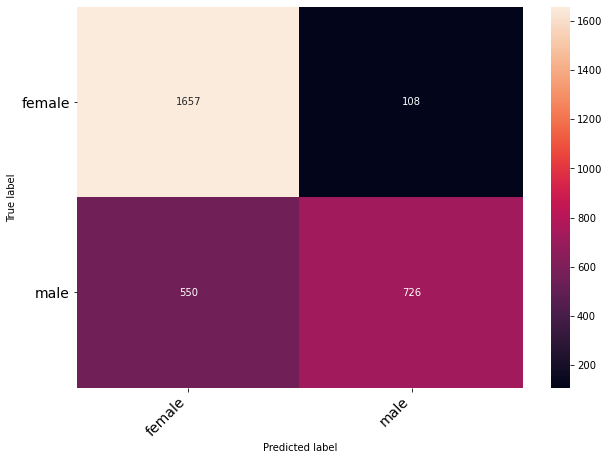

In [51]:
modidf = finaldf
modidf['actualvalues'] = finaldf.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = finaldf.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 

# Matriz de confusión
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [52]:
# Informe de clasificación
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

      female       0.75      0.94      0.83      1765
        male       0.87      0.57      0.69      1276

    accuracy                           0.78      3041
   macro avg       0.81      0.75      0.76      3041
weighted avg       0.80      0.78      0.77      3041



Solo con el género obtenemos una precisión del 78%. El modelo es muy preciso para detectar voces femeninas. Sin embargo, las voces masculinas tienden a ser más duras y comete más errores al pensar que es femenina.

Ahora ignoraremos el género y simplemente agruparemos por las 7 emociones centrales para estudiar la exactitud de la emoción:

0.5014797763893456


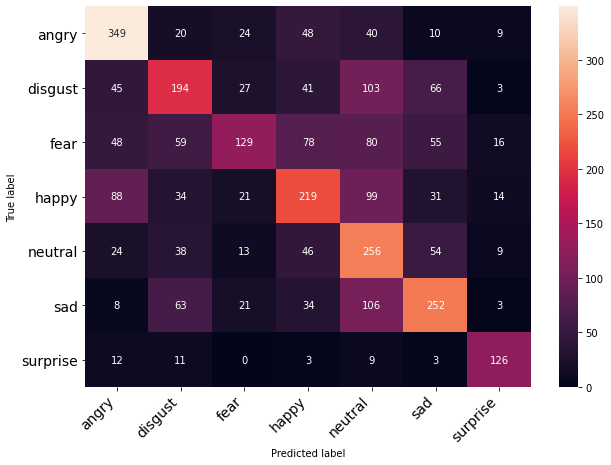

In [53]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Matriz de confusión
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [54]:
# Informe de clasificación
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.61      0.70      0.65       500
     disgust       0.46      0.41      0.43       479
        fear       0.55      0.28      0.37       465
       happy       0.47      0.43      0.45       506
     neutral       0.37      0.58      0.45       440
         sad       0.54      0.52      0.53       487
    surprise       0.70      0.77      0.73       164

    accuracy                           0.50      3041
   macro avg       0.53      0.53      0.52      3041
weighted avg       0.51      0.50      0.50      3041



Se consigue un 50% lo cual no está mal. La precisión de 'Sorpresa' y 'Enfadado' es bastante buena.

La separación de género es curcial para clasificar con precisión las emociones. Las mujeres tienden a expresar emociones de una manera más obvia mientras que los hombres tienden a ser más neutrales (un hombre feliz y enfadado se confunde mucho). Probablemente esta sea la razón por la que vemos que la tasa de error entre los hombres es realmente alta.

## **Aplicar a nuevos datos de audio:**

Para llevar más lejos este estudio se podría aplicar un conjunto de datos de audio nuevo para ver si el clasificador de audio es capaz de generalizar las emociones realmente y no aprenderse las circustancias. Si fuese necesario aplicaríamos Data Augmentation.